In [32]:

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from qolmat.diffusion_model  import ImputerDiffusion
from qolmat.model  import TabDDPM, TsDDPM
from diffusion import DDPM
from load_data import prepare_data, aggregate_market_data
from models import CustomTransformerTimeSeries
from dataloader import TimeSeriesDataset
from models import AutoEncoder, ResidualBlockTS
import joblib
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
START_TRAIN = "1999"
END_TRAIN = "2021"
START_TEST = "2022"
SCALER = 'QT'
data = aggregate_market_data()
df_reindexed, df_orig, df = prepare_data(data, from_year = START_TRAIN,
                                         start_year_test = START_TEST,
                                         scaler = SCALER)
train_df = df_reindexed.loc[:END_TRAIN]
train_df = train_df.interpolate(method='nearest')
X_train = train_df.to_numpy()
X_train = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
df_orig = df_orig['Ret'].unstack().T

100%|██████████| 142/142 [00:03<00:00, 46.49it/s]


failed long_forecasting


c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (100) is greater than the total number of samples (53). n_quantiles is set to n_samples.
  warnings.warn(


In [3]:
sc_loaded = joblib.load('results/'+SCALER+'.save')
original_data = pd.DataFrame(sc_loaded.inverse_transform(df_orig.T).T,columns = df_orig.columns, index = df_orig.index)
original_data
N_OBS = original_data.shape[0]


In [49]:
import random
TICKERS = original_data.columns.tolist()
ticker = random.choices(TICKERS,k=53)
ticker_idx = [TICKERS.index(value) for value in ticker if value in TICKERS]

In [47]:
def sample_sequence(df,n_rows,sequence_size):
    # out = []
    # completed = 0
    # while n_rows - completed > sequence_size:
    #     nrows = range(df.shape[0])
    #     ix = random.randint(nrows.start, nrows.stop-5)
    #     sample = df.iloc[ix:ix+sequence_size, :]
    #     completed+=sequence_size
    #     df.drop(sample.index,axis=0,inplace=True)
    #     out.append(sample)
        
    # last_sample = df.sample(n_rows - completed)
    # out.append(last_sample)
    # new_df = pd.concat(out,axis=0)
    return df.sample(n_rows)

In [73]:
def get_synth_data(original_data:pd.DataFrame,scaler,parameter:str = 'SEQ_LEN',parameter_value:int =21):
    N_OBS = original_data.shape[0]
    path = os.path.join(os.getcwd(),'results','DDPM',parameter,str(parameter_value))
    path_samples = os.path.join(path,'samples.npy')
    samples = np.load(path_samples)
    selected_samples = samples
    reshaped_samples = selected_samples.reshape(-1, selected_samples.shape[-1])
    synth_data = pd.DataFrame(reshaped_samples)
    synth_data = sample_sequence(synth_data,N_OBS,parameter_value)
    
    synth_data_rescaled = pd.DataFrame(scaler.inverse_transform(synth_data.T).T,columns = original_data.columns,
                                    index = original_data.index)
    return synth_data_rescaled

synth_5= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =5)
synth_10= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =10)
synth_21= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =21)
synth_63= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =63)
synth_126= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =126)
synth_252= get_synth_data(original_data= original_data,scaler=sc_loaded,parameter = 'SEQ_LEN',parameter_value =252)



In [74]:
cmpr = pd.concat([synth_5.stack(),
            synth_10.stack(),
            synth_21.stack(),
            synth_63.stack(),
            synth_126.stack(),
            synth_252.stack(),
            original_data.stack()],axis=1,keys = [5,10,21,63,126,252,'original'])


<Axes: xlabel='date'>

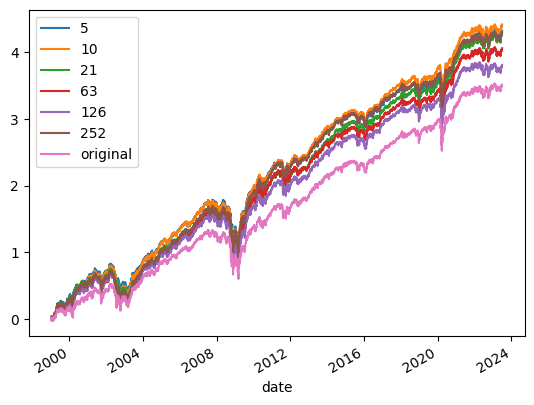

In [75]:
cmpr.groupby(level=0).mean().cumsum().plot()

<Axes: xlabel='date'>

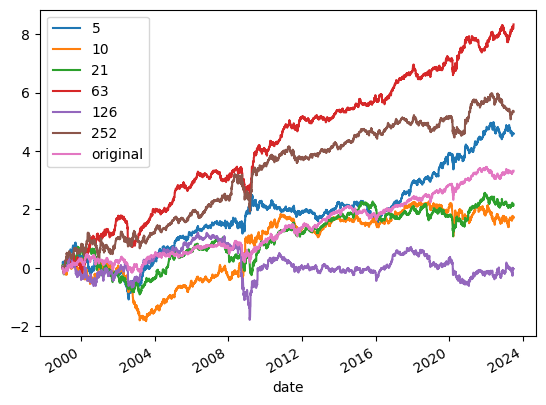

In [77]:
ticker = 'DOV'
cmpr.xs(ticker,level=1).cumsum().plot()